In [2]:
library(Seurat)

# Load single cell RNA Seurat object
scRNA <- readRDS("../../../data/BMMC/scRNA.rds")

# Load scATAC object, which contains cell cluster labels
scATAC <- readRDS("../../../data/BMMC/atac.se.rds")

# Retrieve cell type labels
cluster_labels <- as.character(scATAC@colData$cistopic.assign.l2.rank)

# The initial atlas-based cell type annotation mislabeled DC and GMP.
# We correcte it here
cluster_labels <- sapply(
    cluster_labels,
    function(x){
        if(x == "DC"){x <- "GMP"}
        else if(x == "GMP"){x <- "DC"}
        x
    }
)

In [26]:
# Load cell type markers
marker_table <- as.data.frame(read.table(
    "/home/yanhu/data/PRINT/multiScaleFootprinting/data/BMMC/cell_type_annotation/PanglaoDB/PanglaoDB_markers_27_Mar_2020.tsv",
    sep="\t", header=1
))
marker_table <- marker_table[marker_table$species == "Mm Hs",]

# Only keep relevant cell types
selected_cell_types <- c(
    "NK cells", "Gamma delta T cells", "Thymocytes",
    "B cells", "Plasma cells", 'B cells memory',
    "Hematopoietic stem cells", 'Basophils', "Megakaryocytes", 
    "Erythroid-like and erythroid precursor cells",
    "Monocytes", 'Dendritic cells', 
    "Plasmacytoid dendritic cells"   
)
marker_table <- marker_table[marker_table$cell.type %in% selected_cell_types, ]

PanglaoDB_markers <- lapply(
    selected_cell_types,
    function(cell_type){
        markers <- marker_table$official.gene.symbol[marker_table$cell.type == cell_type]
    }
)
names(PanglaoDB_markers) <- selected_cell_types

In [ ]:
marker_table <- markerList <- readxl::read_excel(
    "/home/yanhu/data/PRINT/multiScaleFootprinting/data/BMMC/cell_type_annotation/CellMarker2.0//Cell_marker_Human.xlsx",
    col_names = T)
marker_table <- marker_table[marker_table$tissue_type == "Bone marrow",]

In [58]:
# Load cell type markers
marker_table <- markerList <- readxl::read_excel(
    "/home/yanhu/data/PRINT/multiScaleFootprinting/data/BMMC/cell_type_annotation/CellMarker2.0//Cell_marker_Human.xlsx",
    col_names = T)
marker_table <- marker_table[marker_table$tissue_type == "Bone marrow",]

# Only keep relevant cell types
selected_cell_types <- c(
    "Naive CD4+ T cell", "GZMK CD8 cell", "Pro-B cell", "Pre-B cell", 
    "Granulocyte-monocyte progenitor cell(GMP)", "Mast cell",
    "Early CD34+ megakaryocyte-erythroid progenitor cell", "Erythroblast",
    "CD16 monocyte","CD14 monocyte", "Myeloid conventional dendritic cell"
)
marker_table <- marker_table[marker_table$cell_name %in% selected_cell_types, ]

CellMarker_markers <- lapply(
    selected_cell_types,
    function(cell_type){
        markers <- marker_table$marker[marker_table$cell_name == cell_type]
    }
)
names(CellMarker_markers) <- selected_cell_types

In [59]:
marker_list <- c(PanglaoDB_markers, CellMarker_markers)

In [60]:
scRNA_counts <- scRNA@assays$RNA@counts

# Get aggregate profile per cluster
unique_clusters <- c(
    "NK", "CD4", "CD8", "CLP", "pro/pre-B",
    "NaiveB", "plasmaB", "MemoryB", 
    "LMPP", "HSC/MPP", "CMP",  "Baso",
    "MEP", "early-Ery", "late-Ery",
    "GMP", "CD16mono", "CD14mono", "DC", "pDC" 
)
cluster_counts <- sapply(
    unique_clusters,
    function(cluster){
        rowSums(scRNA_counts[, cluster_labels == cluster])
    }
)

# Normalize per cluster
cluster_counts <- t(t(cluster_counts) / colMeans(cluster_counts)) * 1e4

# Covert to z-scores
cluster_z_scores <- t(scale(t(cluster_counts)))

In [61]:
signature_scores <- sapply(
    names(marker_list),
    function(cell_type){
        markers <- marker_list[[cell_type]]
        markers <- intersect(markers, rownames(cluster_z_scores))
        if(length(markers) >= 1){
            colMeans(cluster_z_scores[markers, , drop=F])
        }else{
            rep(NA, dim(cluster_z_scores)[2])
        }
    }
)
signature_scores <- signature_scores[, !is.na(colMeans(signature_scores))]

png 
  2

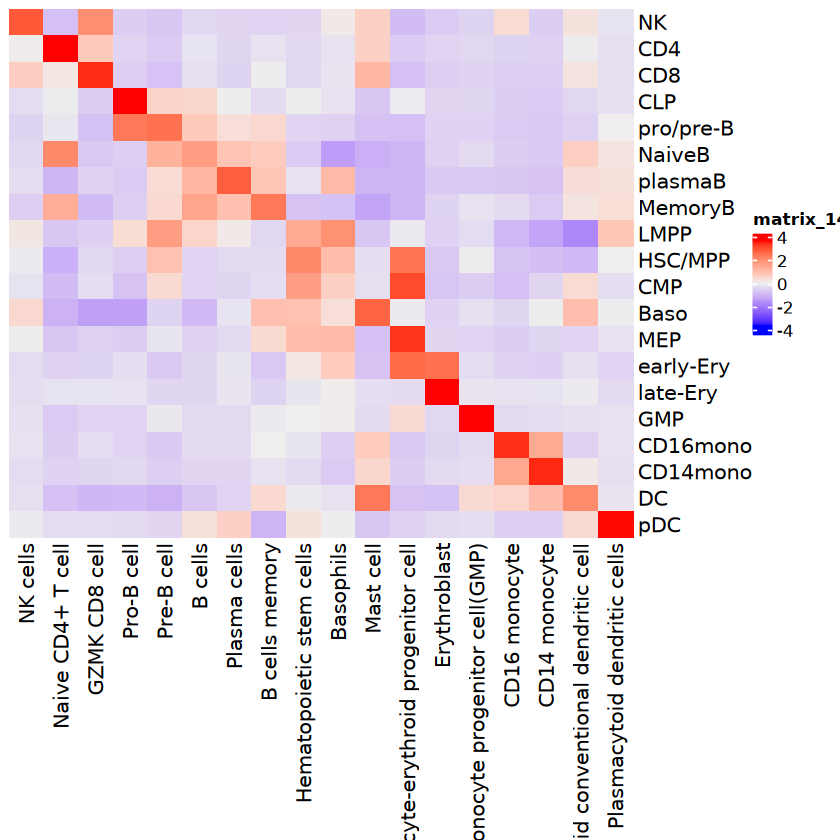

In [62]:
row_order <- unique_clusters
col_order <- c(
    "NK cells", "Naive CD4+ T cell", "GZMK CD8 cell",
    "Pro-B cell", "Pre-B cell", "B cells", "Plasma cells", 'B cells memory',
    "Hematopoietic stem cells", 
    "Basophils", "Mast cell", "Early CD34+ megakaryocyte-erythroid progenitor cell", "Erythroblast",
    "Granulocyte-monocyte progenitor cell(GMP)",
    "CD16 monocyte","CD14 monocyte", "Myeloid conventional dendritic cell",
    "Plasmacytoid dendritic cells"
)
pdf("/home/yanhu/data/PRINT/multiScaleFootprinting/data/BMMC/plots/cellTyping/PanglaoDB_CellMarker2.0.pdf")
p <- ComplexHeatmap::Heatmap(
    t(scale(t(signature_scores[row_order, col_order]))),
    cluster_rows=F, cluster_columns=F
)
p
dev.off()
p